# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

from sklearn.metrics import accuracy_score

from art.utils import load_cifar10
from art.attacks.evasion import CarliniLInfMethod
from art.estimators.classification import TensorFlowV2Classifier

# Load Data

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

# Model

In [3]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(512, activation="relu"),
        Dense(10)
    ])
    model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model

In [4]:
normal_model = create_model()

In [5]:
history = normal_model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
391/391 [==============================] - 7s 13ms/step - loss: 1.4187 - accuracy: 0.4857 - val_loss: 1.1598 - val_accuracy: 0.5810
Epoch 2/10
391/391 [==============================] - 4s 10ms/step - loss: 0.9617 - accuracy: 0.6581 - val_loss: 0.8799 - val_accuracy: 0.6943
Epoch 3/10
391/391 [==============================] - 4s 10ms/step - loss: 0.7529 - accuracy: 0.7362 - val_loss: 0.7833 - val_accuracy: 0.7279
Epoch 4/10
391/391 [==============================] - 4s 10ms/step - loss: 0.5998 - accuracy: 0.7918 - val_loss: 0.7553 - val_accuracy: 0.7428
Epoch 5/10
391/391 [==============================] - 4s 10ms/step - loss: 0.4599 - accuracy: 0.8395 - val_loss: 0.7419 - val_accuracy: 0.7553
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 0.3264 - accuracy: 0.8866 - val_loss: 0.8471 - val_accuracy: 0.7482
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 0.2108 - accuracy: 0.9284 - val_loss: 0.9525 - val_accuracy: 0.7464

In [6]:
classifier = TensorFlowV2Classifier(
    model=normal_model,
    loss_object=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(),
    nb_classes=10,
    input_shape=(32, 32, 3),
    clip_values=(min_, max_)
)

# Carlini-Wagner L-Inf Method

In [7]:
cw_l_inf = CarliniLInfMethod(classifier=classifier, confidence=0.1, batch_size=1, learning_rate=0.01, max_iter=10)

In [8]:
adv_test = cw_l_inf.generate(x=x_test[:4])

C&W L_inf:   0%|          | 0/4 [00:00<?, ?it/s]

# Results

In [9]:
cifar10_class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010005354998158467..0.010006398313185727].


Actual: cat
Prediction using Original Data: cat
Prediction with Adversarial Data: dog


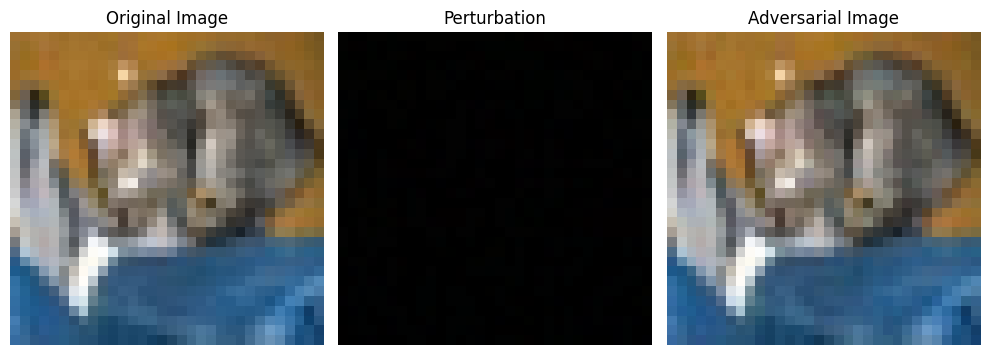

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020048559296364843..0.02005550323748123].



Actual: ship
Prediction using Original Data: ship
Prediction with Adversarial Data: automobile


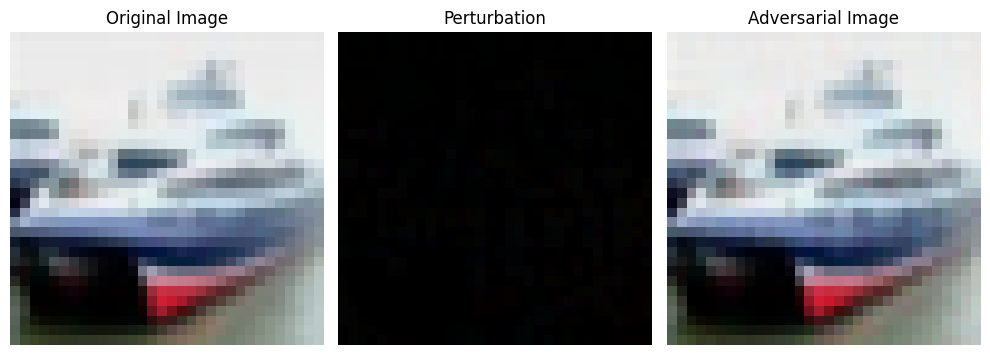

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.004999965546177876..0.004999965546177876].


Actual: ship
Prediction using Original Data: ship
Prediction with Adversarial Data: horse


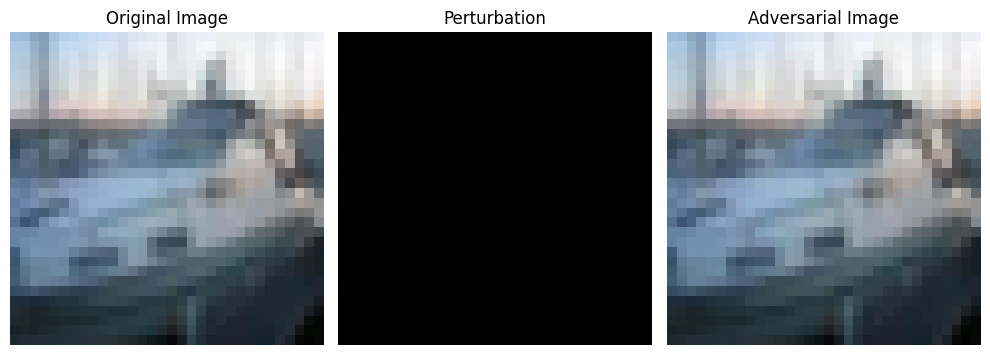

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010005295627257382..0.010004490497065532].


Actual: airplane
Prediction using Original Data: airplane
Prediction with Adversarial Data: ship


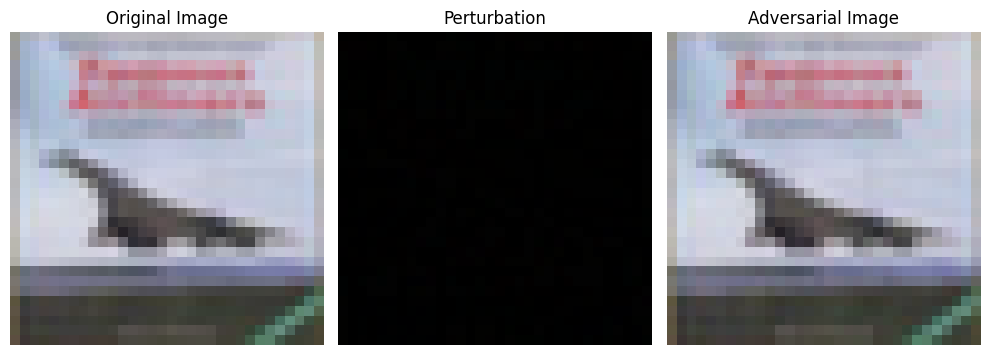

In [10]:
for x_sample, adv_sample, y_sample in zip(x_test[:4], adv_test, y_test[:4]):
    perturbation = adv_sample - x_sample
    perturbation_display = perturbation / (2 * np.max(np.abs(perturbation))) + 0.5
    perturbation_img = image.array_to_img(perturbation_display)

    pred = normal_model.predict(adv_sample.reshape(1, 32, 32, 3), verbose=0)
    label = np.argmax(pred, axis=1)[0]
    pred_label = cifar10_class_labels[label]
    actual_label = cifar10_class_labels[np.argmax(y_sample, axis=0)]
    pred2 = normal_model.predict(x_sample.reshape(-1, 32, 32, 3), verbose=0)
    label2 = np.argmax(pred2, axis=1)[0]
    pred_label2 = cifar10_class_labels[label2]

    print(f"Actual: {actual_label}\nPrediction using Original Data: {pred_label2}\nPrediction with Adversarial Data: {pred_label}")

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))

    axes[0].imshow(x_sample)
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    axes[1].imshow(perturbation, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('Perturbation')

    axes[2].imshow(adv_sample)
    axes[2].axis('off')
    axes[2].set_title('Adversarial Image')

    plt.tight_layout()
    plt.show()

    print()